# SEC Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm

In [11]:
pd.set_option("display.max_columns", 500)

In [2]:
%load_ext lab_black

## Check out Combined Files

In [3]:
# num_files = glob("parquets/numbers*")
# num_files.sort()
# dfs = []
# for f in tqdm(num_files):
#     dfs.append(pd.read_parquet(f))
# dfs = pd.concat(dfs)
# dfs.to_parquet("numbers.parquet")

In [4]:
numbers = pd.read_parquet("numbers.parquet")
subs = pd.read_parquet("parquets/submissions_combined.parquet")
subs["accepted"] = pd.to_datetime(subs["accepted"])

# Explore the "Submission" Data
- This lists all the submissions made to the SEC and the form/company names.

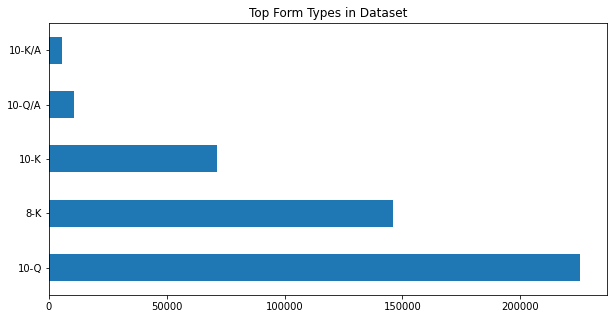

In [33]:
subs["form"].value_counts().head(5).plot(
    kind="barh", figsize=(10, 5), title="Top Form Types in Dataset"
)
plt.show()

In [34]:
subs.groupby("ein")["name"].nunique().sort_values().value_counts()

1       9134
2       2413
3        455
4         82
5         10
6          4
7          1
8          1
9          1
4684       1
Name: name, dtype: int64

# Explore a Subset of the Data
- microsoft
- kpmg
- nvidia
- tesla
- twitter
- coke
- bbwi
- intel
- gamestop
- icid
- pltr

In [162]:
companies = [
    "microsoft",
    # "kpmg",
    "nvidia",
    "tesla",
    "twitter",
    "coca cola co",
    "bath & body works",
    "INTEL CORP",
    "gamestop",
    # "icid",
    "Palantir",
]
companies = [c.upper() for c in companies]

In [163]:
names = []
for c in companies:
    print(f"========== {c} =========")
    matched_names = subs.loc[subs["name"].str.startswith(c)]["name"].unique()
    names += matched_names.tolist()
    print(matched_names)

========== MICROSOFT =========
['MICROSOFT CORP']
========== NVIDIA =========
['NVIDIA CORP']
========== TESLA =========
['TESLA, INC.' 'TESLA MOTORS INC']
========== TWITTER =========
['TWITTER, INC.']
========== COCA COLA CO =========
['COCA COLA CO']
========== BATH & BODY WORKS =========
['BATH & BODY WORKS, INC.']
========== INTEL CORP =========
['INTEL CORP']
========== GAMESTOP =========
['GAMESTOP CORP.']
========== PALANTIR =========
['PALANTIR TECHNOLOGIES INC.']


In [180]:
subs_ = subs.loc[subs["name"].isin(names)].reset_index(drop=True).copy()
subs_10q = subs_.query('form in ["10-Q","10-K"]')

adsh_subset = subs_10q["adsh"].unique().tolist()
print("Number of filings", len(adsh_subset))

Number of filings 352


## CIK - Unique per company
- Note that tesla changed their name, but the CIK stays the same.

In [181]:
subs_.groupby("cik")["name"].unique()

cik
21344                       [COCA COLA CO]
50863                         [INTEL CORP]
701985           [BATH & BODY WORKS, INC.]
789019                    [MICROSOFT CORP]
1045810                      [NVIDIA CORP]
1318605    [TESLA, INC., TESLA MOTORS INC]
1321655       [PALANTIR TECHNOLOGIES INC.]
1326380                   [GAMESTOP CORP.]
1418091                    [TWITTER, INC.]
Name: name, dtype: object

In [182]:
# Subset the "Number" data to these companies 10-Q filings
num_ = numbers.query("adsh in @adsh_subset").reset_index(drop=True).copy()

## Explore the "tag" values for 10-Q

In [183]:
num_["tag"].value_counts().head(20)

NetIncomeLoss                                      1499
GrossProfit                                        1341
CashAndCashEquivalentsAtCarryingValue              1333
EarningsPerShareBasic                              1331
EarningsPerShareDiluted                            1331
OperatingIncomeLoss                                1275
IncomeTaxExpenseBenefit                            1120
WeightedAverageNumberOfDilutedSharesOutstanding    1081
WeightedAverageNumberOfSharesOutstandingBasic      1073
InterestExpense                                    1044
ComprehensiveIncomeNetOfTax                        1013
StockholdersEquity                                  920
SellingGeneralAndAdministrativeExpense              854
InvestmentIncomeInterest                            851
OtherNonoperatingIncomeExpense                      839
ShareBasedCompensation                              814
CommonStockDividendsPerShareDeclared                806
ResearchAndDevelopmentExpense                   

## Pick a subset of fields to focus on
- GrossProfit
- NetIncomeLoss
- CashAndCashEquivalentsAtCarryingValue
- Assets
- StockholdersEquity
- EarningsPerShareBasic

## Data Wrangling

In [184]:
subs_ = subs.loc[subs["name"].isin(names)].reset_index(drop=True).copy()
num_ = numbers.query("adsh in @adsh_subset").reset_index(drop=True).copy()
num_ = num_.merge(subs_[["adsh", "period", "name", "cik"]], validate="m:1")
num_["period"] = pd.to_datetime(num_["period"], format="%Y%m%d")
num_["name_latest"] = num_["cik"].map(num_.groupby("cik")["name"].last())

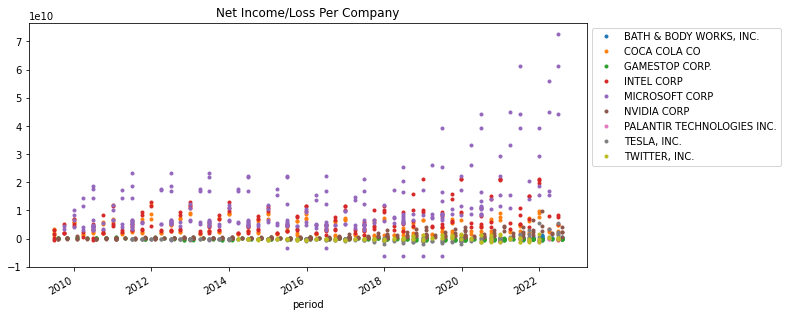

In [185]:
fig, ax = plt.subplots(figsize=(10, 5))
num_.query('tag == "NetIncomeLoss"').set_index("period").groupby(["name_latest"])[
    "value"
].plot(style=".", ax=ax, title="Net Income/Loss Per Company")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Plot Income/Loss by Company

/tmp/ipykernel_2832437/776611570.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for company, d in num_.query('tag == "NetIncomeLoss" and qtrs == 1').groupby(


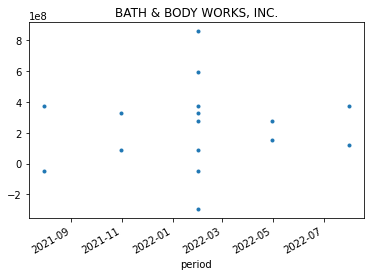

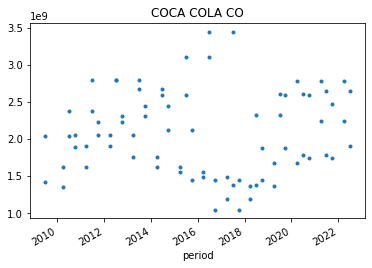

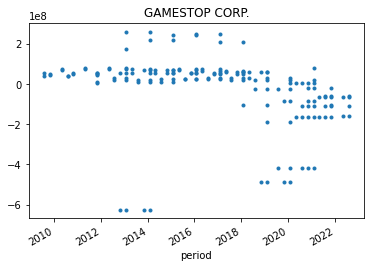

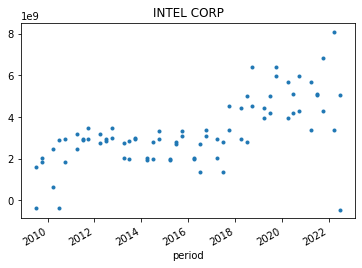

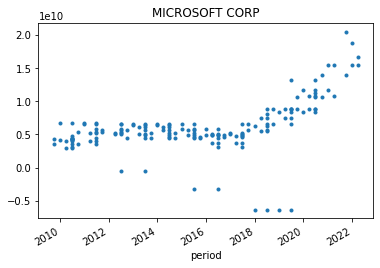

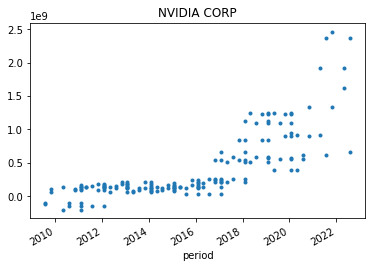

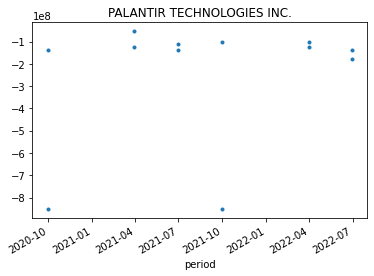

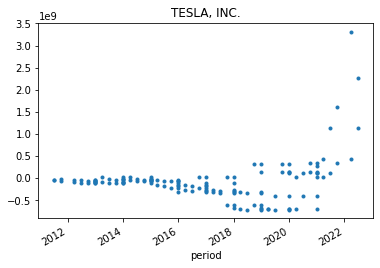

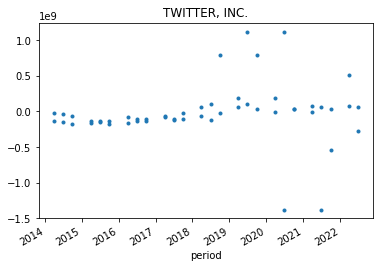

In [210]:
for company, d in num_.query('tag == "NetIncomeLoss" and qtrs == 1').groupby(
    ["name_latest"]
):
    d.set_index("period")["value"].plot(title=company, style=".")
    plt.show()

In [217]:
num_["ddate"] = pd.to_datetime(num_["ddate"], format="%Y%m%d")

In [225]:
import plotly.express as px

In [230]:
num_.query(
    'name_latest == "GAMESTOP CORP." and tag == "NetIncomeLoss" and qtrs == 1'
).query("value < -500_000_000")

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote,filename,period,name,cik,name_latest
26835,0001193125-12-492205,NetIncomeLoss,us-gaap/2012,None,2012-10-31,1,USD,-624300000.0,None,2012q4/num.txt,2012-10-31,GAMESTOP CORP.,1326380,GAMESTOP CORP.
29469,0001193125-13-140443,NetIncomeLoss,us-gaap/2012,None,2012-10-31,1,USD,-624300000.0,None,2013q2/num.txt,2013-01-31,GAMESTOP CORP.,1326380,GAMESTOP CORP.
36741,0001193125-13-470097,NetIncomeLoss,us-gaap/2013,None,2012-10-31,1,USD,-624300000.0,None,2013q4/num.txt,2013-10-31,GAMESTOP CORP.,1326380,GAMESTOP CORP.
43364,0001445305-14-001259,NetIncomeLoss,us-gaap/2013,None,2012-10-31,1,USD,-624300000.0,None,2014q2/num.txt,2014-01-31,GAMESTOP CORP.,1326380,GAMESTOP CORP.


In [248]:
# [t for t in num_["tag"].unique().tolist() if "CashFlow" in t]

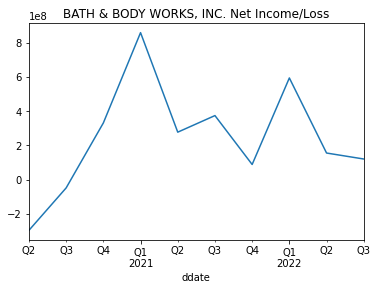

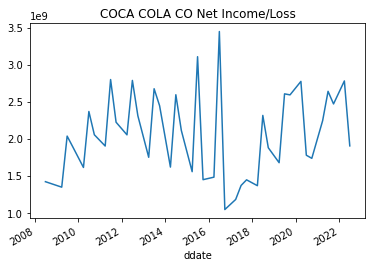

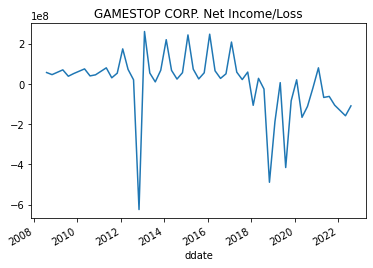

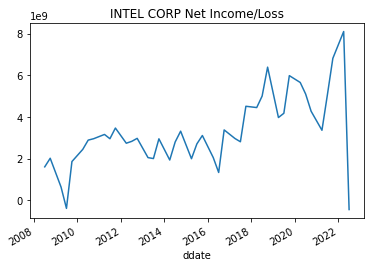

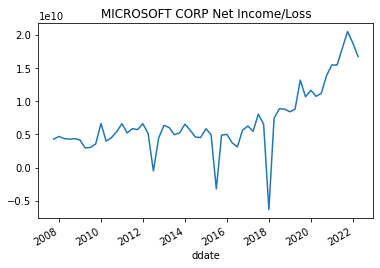

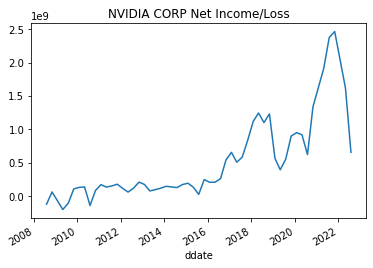

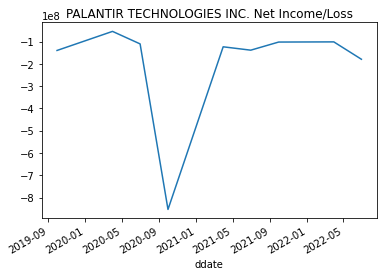

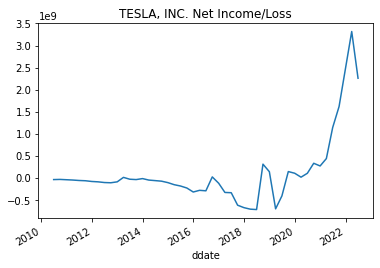

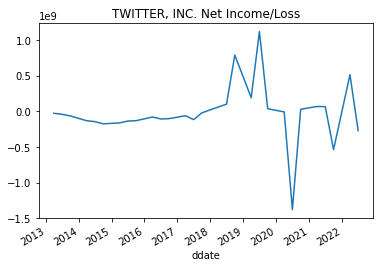

In [245]:
for company, d in num_.groupby("name_latest"):
    d2 = (
        d.query('tag == "NetIncomeLoss" and qtrs == 1').groupby("ddate")["value"].last()
    )

    d2.plot(title=f"{company} Net Income/Loss")
    plt.show()

In [250]:
# num_.query(
#     'name_latest == "GAMESTOP CORP." and tag == "NetIncomeLoss" and qtrs == 1'
# ).sort_values(
#     "period"
# )  # [["name_latest", "tag", "period", "qtrs", "ddate", "value"]]

In [251]:
# [t for t in num_["tag"].unique() if "NetIncomeLoss" in t]

# Earnings Per Share

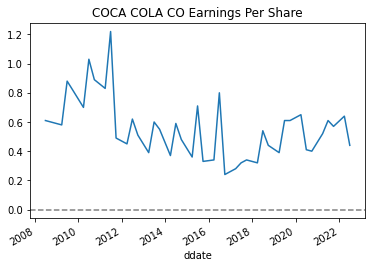

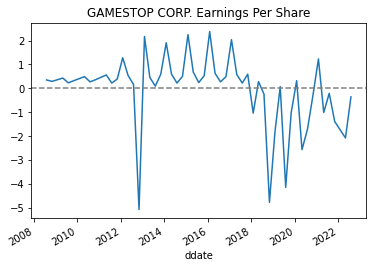

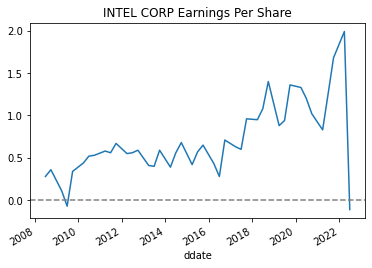

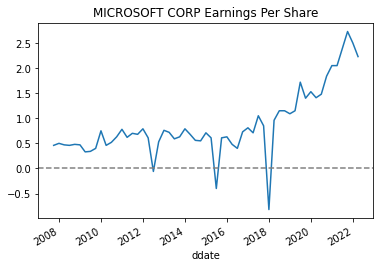

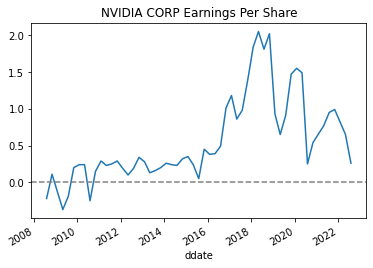

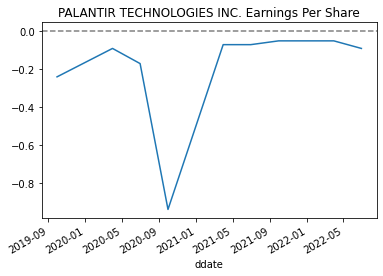

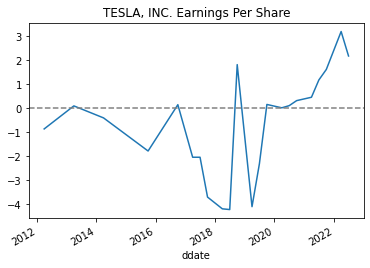

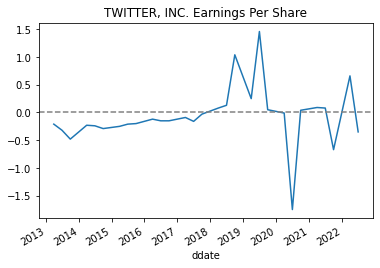

In [258]:
# EarningsPerShareBasic

for company, d in num_.groupby("name_latest"):
    if company == "BATH & BODY WORKS, INC.":
        continue
    d2 = (
        d.query('tag == "EarningsPerShareBasic" and qtrs == 1')
        .groupby("ddate")["value"]
        .last()
    )

    ax = d2.plot(title=f"{company} Earnings Per Share")
    ax.axhline(0, ls="--", color="grey")
    plt.show()

In [261]:
# num_["tag"].unique().tolist()

In [266]:
# num_.query('tag == "CashAndCashEquivalentsAtCarryingValue"')

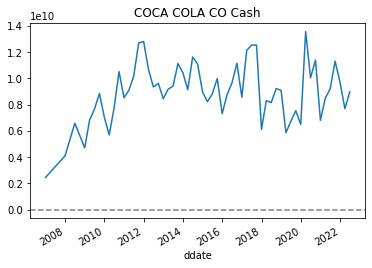

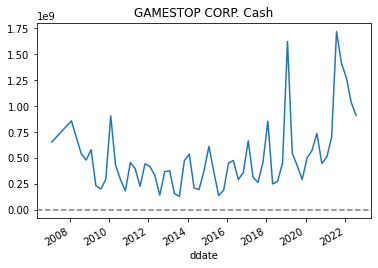

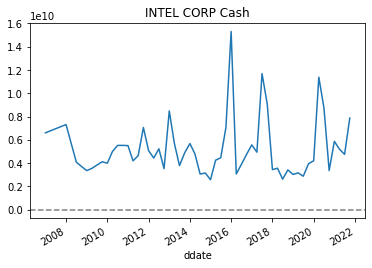

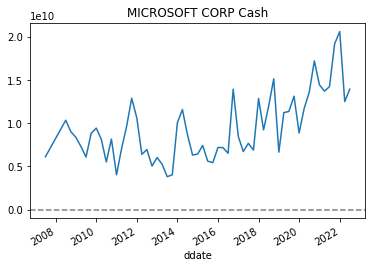

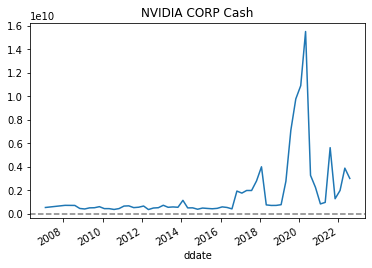

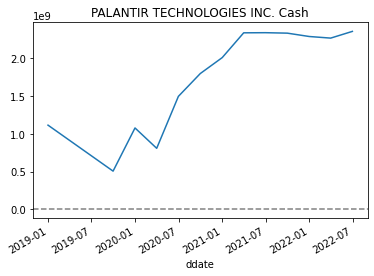

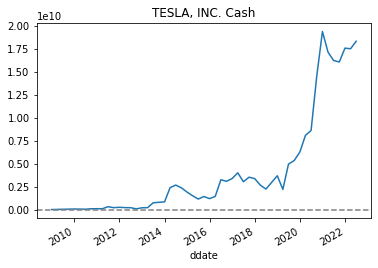

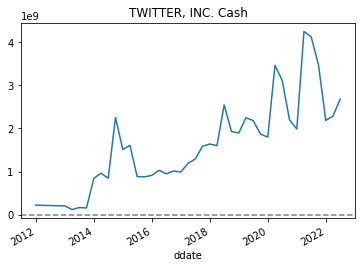

In [267]:
# EarningsPerShareBasic

for company, d in num_.groupby("name_latest"):
    if company == "BATH & BODY WORKS, INC.":
        continue
    d2 = (
        d.query('tag == "CashAndCashEquivalentsAtCarryingValue" and qtrs == 0')
        .groupby("ddate")["value"]
        .last()
    )

    ax = d2.plot(title=f"{company} Cash")
    ax.axhline(0, ls="--", color="grey")
    plt.show()